In [ ]:
"""
examines catA-v3 versus covref4 alignments
"""


In [1]:
pip install pysam

    100% |████████████████████████████████| 10.0MB 227kB/s ta 0:00:011
Note: you may need to restart the kernel to use updated packages.


In [39]:
import pysam
from collections import defaultdict

import seaborn as sns
import pandas as pd
import matplotlib.pylab as plt

In [81]:
assemblies="catA-v3"
sam = pysam.AlignmentFile("%s-vs-covref4.sam" %assemblies)

divs = []
alns = dict()
best_aln_score_per_query = dict()
alns_query = defaultdict(list)
alns_query_len = dict()
for aln in sam.fetch():
    query_name = aln.query_name
    query_length = aln.query_length
    ref_name = aln.reference_name
    if aln.has_tag('AS'):
        alignment_score = int(aln.get_tag('AS'))
    else:
        alignment_score = None
        print(query_name,ref_name,"no AS")
    if aln.has_tag('de'):
        div  = float(aln.get_tag('de'))
    else:
        div = None
        print(query_name,ref_name,"no de")
    #print(query_name,ref_name,alns,div)
    
    if div is None: continue
        
    # keep all alignments
    # divs += [(div,query_name,ref_name,alignment_score)]

    # record the best alignment per query
    if query_name not in best_aln_score_per_query:
        best_aln_score_per_query[query_name] = (div,query_name,ref_name,alignment_score)
    else:
        d,q,r,a = best_aln_score_per_query[query_name]
        #if d < div: 
        # only update if better alignment score
        if alignment_score > a: 
             best_aln_score_per_query[query_name] = (div,query_name,ref_name,alignment_score)
    
    alns[(query_name,ref_name)] = aln
    alns_query[query_name] += [ref_name]
    
    if query_name not in alns_query_len:
        alns_query_len[query_name] = query_length
    else:
        # for some reason i can't just record any hit
        alns_query_len[query_name] = max(query_length,alns_query_len[query_name])
            
    #print(aln)
    #break

divs = best_aln_score_per_query.values()
#print(divs)
#print(sorted(divs))

# analysis of the worst contig, the one which aligns with worst div
most_distant = sorted(divs)[-1]
div,q,r,a = most_distant
print("best alignment of worst query:",alns[(q,r)])
print("all alignments of worst query")
for r2 in alns_query[q]:
    print(alns[(q,r2)])
    


SRR10873981 None no AS
SRR10873981 None no de
SRR10873977 None no AS
SRR10873977 None no de
best alignment of worst query: SRR1522982	272	491	21699	0	21800S1253M3I2192M62I1016M5I2M8D22M3I6M12I2176M6D571M3I103M43S	-1	-1	7429	None	None	[('NM', 764), ('ms', 937), ('AS', 426), ('nn', 0), ('tp', 'S'), ('cm', 132), ('s1', 1731), ('de', 0.09120000153779984), ('zd', 2), ('rl', 0)]
all alignments of worst query
SRR1522982	272	491	21699	0	21800S1253M3I2192M62I1016M5I2M8D22M3I6M12I2176M6D571M3I103M43S	-1	-1	7429	None	None	[('NM', 764), ('ms', 937), ('AS', 426), ('nn', 0), ('tp', 'S'), ('cm', 132), ('s1', 1731), ('de', 0.09120000153779984), ('zd', 2), ('rl', 0)]
SRR1522982	272	149	45	0	179S3207M25886S	-1	-1	3207	None	None	[('NM', 258), ('ms', 739), ('AS', 627), ('nn', 0), ('tp', 'S'), ('cm', 64), ('s1', 847), ('de', 0.0803999975323677), ('zd', 1), ('rl', 0)]
SRR1522982	272	497	6178	0	6293S14211M8768S	-1	-1	14211	None	None	[('NM', 796), ('ms', 6251), ('AS', 6251), ('nn', 0), ('tp', 'S'), ('cm', 459

worst alignment scores
    Assembly  Length  BestAlignmentScore BestReference
  ERR4164903   32040                1474   NC_045512.2
  SRR1522982   29272                6889    EU186072.1
  SRR8181896   27713                8005    DQ288927.1
  SRR9214144   31500                8767    FJ647222.1
  ERR4018349   27612               10231    MN711790.1
  SRR8062425   31426               11919   NC_048217.1
  SRR7716792   31492               12059   NC_048217.1
  SRR7716793   31483               12062   NC_048217.1
  SRR8791646   31488               12230   NC_048217.1
 SRR10834677   31431               12429   NC_001846.1
  ERR4181727   29749               15226    MT374101.1
 SRR10875068   26349               15401   NC_011549.1
  SRR7623977   27342               15667    LC260045.1
 SRR10873770   26309               15868   NC_011549.1
 SRR11621817   29932               15895   NC_045512.2
 SRR11780000   29866               17127    MT334557.1
 SRR11621829   29480               17127  

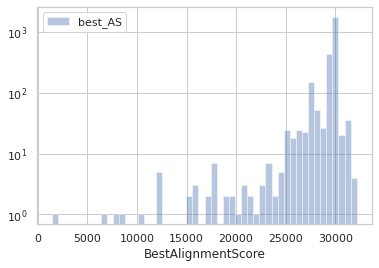

In [100]:
# plot alignment scores
best_alignment_scores = [(query_name,alns_query_len[query_name],
                          best_aln_score_per_query[query_name][3],
                          best_aln_score_per_query[query_name][2]) for query_name in best_aln_score_per_query]
#rint(best_alignment_scores)
data_best_alignment_scores= pd.DataFrame(best_alignment_scores, columns=['Assembly', 'Length','BestAlignmentScore','BestReference'])

sns.set(style="whitegrid")
ax = sns.distplot(data_best_alignment_scores['BestAlignmentScore'], kde=False, label="best_AS")
ax.set_yscale('log')
plt.legend()

print("worst alignment scores")
print(data_best_alignment_scores.sort_values(by=['BestAlignmentScore'])[:30].to_string(index=False))


print(len(data_best_alignment_scores[data_best_alignment_scores['BestAlignmentScore'] <= 24500]),"highly suspicious catA accessions out of",len(data_best_alignment_scores))
data_best_alignment_scores.to_csv('%s-to-covref4.alignment_scores.csv' % assemblies)

In [122]:
# Finding assemblies for which alignment score is not too close to their length but also not too far
# (maybe novel viruses?)
counter = 0
for accession in \
data_best_alignment_scores[
    (data_best_alignment_scores['BestAlignmentScore'] >= 0.8*data_best_alignment_scores['Length'])
    & 
    (data_best_alignment_scores['BestAlignmentScore'] <= 0.95*data_best_alignment_scores['Length'])
    ]['Assembly']:
    entry = data_best_alignment_scores[data_best_alignment_scores['Assembly'] == accession]
    print(entry)
    ref = entry['BestReference'].values[0]
    print("cigar",alns[(accession,ref)].cigarstring)
    counter += 1
print(counter,"entries")

     Assembly  Length  BestAlignmentScore BestReference
9  SRR1191915   32532               30054   NC_019843.3
cigar 30094M2438S
      Assembly  Length  BestAlignmentScore BestReference
40  SRR6893880   25412               23327    LC260045.1
cigar 43S3143M3I22216M7S
      Assembly  Length  BestAlignmentScore BestReference
42  SRR5872029   27464               25319   NC_005831.2
cigar 27449M15S
      Assembly  Length  BestAlignmentScore BestReference
58  SRR5872113   27483               25827   NC_005831.2
cigar 45S27437M1S
       Assembly  Length  BestAlignmentScore BestReference
144  SRR5871961   27507               25307   NC_005831.2
cigar 27507M
       Assembly  Length  BestAlignmentScore BestReference
169  SRR6713743   28153               25836    KJ645704.1
cigar 130S26006M2017S
       Assembly  Length  BestAlignmentScore BestReference
186  ERR1399348   27548               25086   NC_005831.2
cigar 27546M2S
       Assembly  Length  BestAlignmentScore BestReference
196  SRR10338